In [1]:
# importing the libraries
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
# mounting the drive 
from google.colab import drive

drive.mount("/content/gdrive")
!unzip '/content/gdrive/MyDrive/2.zip'

Streaming output truncated to the last 5000 lines.
 extracting: 1/train/bird/emu_s_000219.png  
 extracting: 1/train/bird/pipit_s_000192.png  
 extracting: 1/train/bird/flightless_bird_s_000562.png  
 extracting: 1/train/bird/passerine_s_001221.png  
 extracting: 1/train/bird/struthio_camelus_s_000008.png  
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610.png  
 extracting: 1/train/bird/cassowary_s_0

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)


        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=5)
        # self.fc5 = nn.Linear(in_features=1024, out_features=5)

         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # x = F.relu(self.fc4(x))
        # x = self.dropout(x)
        x=self.fc4(x)
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()
net.load_state_dict(torch.load("/content/gdrive/MyDrive/last(5+4+relu)model.pth",map_location ='cpu'))
# if torch.cuda.is_available():


# model.load_state_dict(torch.load())

<All keys matched successfully>

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])

test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 


testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)
print(type(testset))
print(type(testloader))
print(len(testset))



<class 'torchvision.datasets.folder.ImageFolder'>
<class 'torch.utils.data.dataloader.DataLoader'>
2500


In [50]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, _ = find_classes(test_data_dir)

In [57]:
def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(test_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # if torch.cuda.is_available():
            #     images, labels = images.cuda(), labels.cuda() 
            images, labels = images.cpu(), labels.cpu()         
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
classwise_test(testloader, net)

100%|██████████| 625/625 [00:13<00:00, 45.59it/s]

Accuracy of  aeroplane : 85.600000 %
Accuracy of       bird : 80.800000 %
Accuracy of        cat : 64.000000 %
Accuracy of        dog : 82.000000 %
Accuracy of       ship : 88.800000 %


In [56]:
def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # if torch.cuda.is_available():
            #     images, labels = images.cuda(), labels.cuda() 
            images, labels = images.cpu(), labels.cpu()         
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)
test(testloader,net)

100%|██████████| 625/625 [00:13<00:00, 45.78it/s]

Accuracy of the network on the test images: 80.280000 %


80.28

In [16]:


target_labels=[]
def correct_prediction_ohe(net,testloader):
   prepred_labels=[]
   correct=0
   total=2500
   
   with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # print(labels.shape)
            # print(images.shape)
            # print(labels[3])
            # print(outputs.shape)
            # if torch.cuda.is_available():
            #     images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            # print(outputs.data.shape)
            # print(outputs.data)
            prop, predicted = torch.max(outputs.data, 1)
            # print(predicted[3])
            
            for i in range (4):
              #  print(type(labels[0]))
              #  print(type(predicted[0]))
               target_labels.append(labels[i])
               prepred_labels.append(predicted[i])
               if (labels[i]==predicted[i]):
                  correct+=1
            
            # if ohes==None:
            #   ohes=ohe
            # else:

            #   ohes=torch.cat((ohes,ohe),dim=0)
           
   
   print("\n")
   print(correct)
   print("accuracy before switching the weights ",correct/total)
   return prepred_labels
  #  print(ohes.shape)
  #  return ohes,predicted_labels,target_labels
prepred_labels=correct_prediction_ohe(net,testloader)

100%|██████████| 625/625 [00:14<00:00, 43.57it/s]



1986
accuracy before switching the weights  0.7944


In [17]:
print(len(target_labels))
print(len(prepred_labels))

2500
2500


In [18]:
preindex=[]
i=0
for i in range (2500):
  if (prepred_labels[i]!=target_labels[i]):

    preindex.append(i)

In [19]:
print(len(preindex))
# thes are the indexes of the mis-classifies images before weights were switched to zero

514


In [20]:
# switching the weights of the model to zero
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
filter_idx = {'conv1' : [3,31], 'conv2' : [4,63], 'conv3' : [5,80], 'conv4' : [100,200], 'conv5':[10,250]}
with torch.no_grad():
  net.conv1.weight[3]=0
  net.conv1.weight[31]=0

  net.conv2.weight[4]=0
  net.conv2.weight[63]=0

  net.conv3.weight[5]=0
  net.conv3.weight[80]=0

  net.conv4.weight[100]=0
  net.conv4.weight[200]=0

  net.conv5.weight[10]=0
  net.conv5.weight[250]=0

In [22]:
def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # if torch.cuda.is_available():
            #     images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)
test(testloader,net)

100%|██████████| 625/625 [00:13<00:00, 46.50it/s]

Accuracy of the network on the test images: 79.040000 %


79.04

In [25]:
tar_labels=[]
def correct_pprediction_ohe(net,testloader):
   postpred_labels=[]
   
   correct=0
   total=2500
   
   with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # print(labels.shape)
            # print(images.shape)
            # print(labels[3])
            # print(outputs.shape)
            # if torch.cuda.is_available():
            #     images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            # print(outputs.data.shape)
            # print(outputs.data)
            prop, predicted = torch.max(outputs.data, 1)
            # print(predicted[3])
            
            for i in range (4):
              #  print(type(labels[0]))
              #  print(type(predicted[0]))
               tar_labels.append(labels[i])
               postpred_labels.append(predicted[i])
               if (labels[i]==predicted[i]):
                  correct+=1
            
            # if ohes==None:
            #   ohes=ohe
            # else:

            #   ohes=torch.cat((ohes,ohe),dim=0)
           
   
   print("\n")
   print(correct)
   print("accuracy before switching the weights ",correct/total)
   return postpred_labels

In [26]:
postpred_labels=correct_pprediction_ohe(net,testloader)

100%|██████████| 625/625 [00:13<00:00, 45.82it/s]



1987
accuracy before switching the weights  0.7948


In [29]:
def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(test_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # if torch.cuda.is_available():
            #     images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
classwise_test(testloader, net)

100%|██████████| 625/625 [00:13<00:00, 45.88it/s]

Accuracy of  aeroplane : 85.800000 %
Accuracy of       bird : 82.200000 %
Accuracy of        cat : 62.600000 %
Accuracy of        dog : 80.800000 %
Accuracy of       ship : 89.000000 %


In [30]:
print(len(postpred_labels))
print(len(target_labels))

2500
2500


In [31]:
postindex=[]
i=0
for i in range (2500):
  if (postpred_labels[i]!=target_labels[i]):

    postindex.append(i)

In [32]:
len(postindex)

513

In [33]:
index=[]
for i in postindex:
  if i not in preindex:
    index.append(i)


In [36]:
print(len(index))
index

92


[22,
 33,
 38,
 61,
 89,
 134,
 161,
 284,
 292,
 371,
 391,
 418,
 450,
 461,
 490,
 502,
 511,
 566,
 615,
 676,
 682,
 737,
 767,
 893,
 899,
 916,
 929,
 942,
 1016,
 1022,
 1028,
 1037,
 1066,
 1072,
 1098,
 1150,
 1158,
 1161,
 1163,
 1216,
 1234,
 1246,
 1254,
 1275,
 1285,
 1290,
 1295,
 1296,
 1299,
 1305,
 1307,
 1311,
 1354,
 1387,
 1401,
 1408,
 1424,
 1425,
 1438,
 1442,
 1461,
 1484,
 1488,
 1498,
 1499,
 1560,
 1600,
 1640,
 1644,
 1654,
 1696,
 1740,
 1772,
 1777,
 1789,
 1809,
 1823,
 1854,
 1858,
 1875,
 1909,
 1928,
 1955,
 1964,
 2045,
 2060,
 2070,
 2211,
 2236,
 2274,
 2414,
 2455]

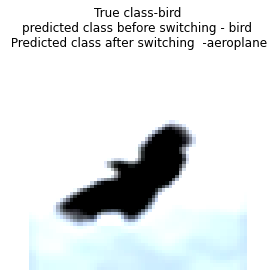

In [48]:
def display(image,i):
  # image is atensor so have to convert to numpy
  img=image.numpy()
  # image standard scalar
  img=img-np.min(img)/abs(np.max(img)-np.min(img))
  title = 'True class-'+classes[target_labels[i]]+'\npredicted class before switching - '+classes[prepred_labels[i]] + '\n Predicted class after switching  -'+ classes[postpred_labels[i]]
    
  # print("true class",classes[target_labels[i]])
  # print("predicted class",classes[predicted_labels[i]])
  # reshape image from (3,64,64) to (64,64,3)  
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis("off")
  
  plt.title(title)
# for i in index:
import matplotlib.pyplot as plt

def images(i):
    #considers one image 
    image, label = testloader.dataset[i]
    outputs = net(image[None,:,:,:])
    _, predicted = torch.max(outputs, 1)
    
    
    display(image,i)
images(566)
   
   
#plt.savefig('../images/misclassified_imgs.png')

